In [81]:
import pandas as pd

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df = pd.read_csv(url)

# US County Level
us_county_only = df[(df['Country/Region'] == 'US') & (df['Province/State'].str.contains(', ', na=False))].drop(['Lat', 'Long'], axis=1)
county_state = us_county_only['Province/State'].str.split(', ', n = 1, expand = True)
us_county_only.insert(0, 'County',county_state[0])
us_county_only.insert(1, 'State', county_state[1])
us_county_only.drop(columns =['Province/State'], inplace = True)

# Aggregate at country level
country_level = df[~(df['Province/State'].str.contains(', ', na=False))].drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

def align(data):
    # Find the index with the lowest non-zero starting case number
    base = min(((idx, val) for (idx, val) in enumerate(data) if val[0] > 0), key = lambda x: x[1][0])[0]

    # Align everyone else to this base
    for i in [x for x in range(len(data)) if x != base]:
        padding = min(((x[0], abs(x[1] - data[i][0])) for x in enumerate(data[base])), key = lambda x: x[1])[0]
        data[i] = [0 for i in range(padding)] + data[i]
    return data

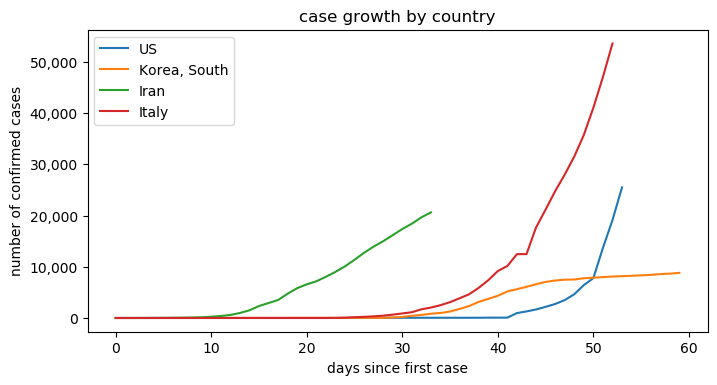

In [82]:
from pylab import *

# Countries to compare
inputs = ['US', 'Korea, South', 'Iran', 'Italy']
data = align([[x for x in country_level.loc[inputs[i]].values.tolist() if x > 0] for i in range(len(inputs))])

fig, axes = plt.subplots(figsize=(8,4), dpi=100)

for i in range(len(data)):
    axes.plot(data[i], label = inputs[i])

axes.legend(loc=2)
axes.set_xlabel('days since first case')
axes.set_ylabel('number of confirmed cases')
axes.set_title('case growth by country');
axes.set_yticklabels(['{:,}'.format(int(x)) for x in axes.get_yticks().tolist()])

fig.savefig("covid-by-country.png", dpi=200)

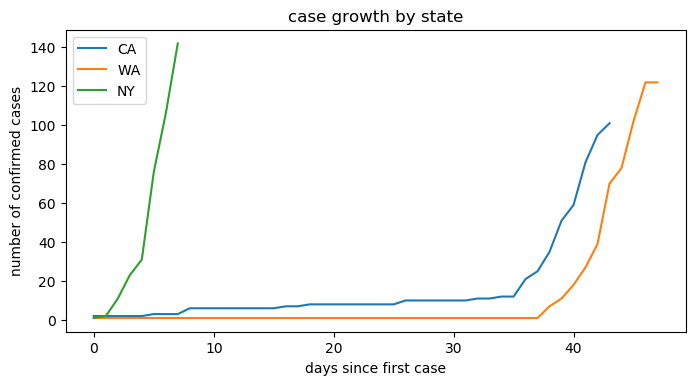

In [83]:
inputs = ['CA', 'WA', 'NY']
us_by_state = us_county_only.groupby('State').sum()
data = align([[x for x in us_by_state.loc[inputs[i]].values.tolist() if x > 0] for i in range(len(inputs))])

fig, axes = plt.subplots(figsize=(8,4), dpi=100)

for i in range(len(data)):
    axes.plot(data[i], label = inputs[i])

axes.legend(loc=2)
axes.set_xlabel('days since first case')
axes.set_ylabel('number of confirmed cases')
axes.set_title('case growth by state');

fig.savefig("covid-by-us-state.png", dpi=200)

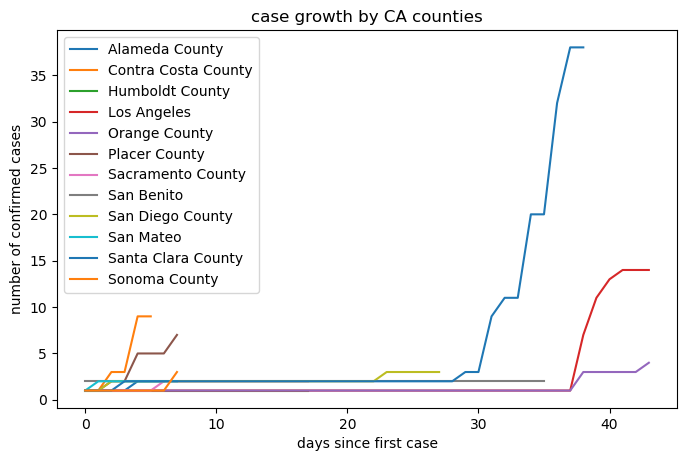

In [84]:
state = 'CA'
state_by_county = us_county_only[us_county_only['State'] == state].groupby('County').sum()
inputs = state_by_county.index.tolist()
data = [[x for x in state_by_county.loc[inputs[i]].values.tolist() if x > 0] for i in range(len(inputs))]
data = [datum for datum in data if len(datum) > 0]
data = align(data)

fig, axes = plt.subplots(figsize=(8,5), dpi=100)

for county in state_by_county.index:
    data = [x for x in state_by_county.loc[county].values.tolist() if x > 0]
    if len(data) <= 5:
        continue
    axes.plot(data, label = county)

axes.legend(loc=2)
axes.set_xlabel('days since first case')
axes.set_ylabel('number of confirmed cases')
axes.set_title('case growth by %s counties' % state);

fig.savefig("covid-by-%s-counties.png" % state, dpi=200)